<a href="https://colab.research.google.com/github/Amir-Fasil/RAG-for-LLMs/blob/main/Amir_Fasil_Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**I am going to use the same queries from TASK-1:**

*   "What is LeBron James' weight?"
*    "list of players?"
*   "Who are LeBron James' teammates?"
*   "What is Tobias Harris' age?"
*   "Who are LeBron James' opponents?"
*   "What is Tobias Harris' weight?"


**Fisrt let's install all necessary modules, frameworks, libraries...**

In [ ]:
!pip install neo4j

In [ ]:
from neo4j import GraphDatabase # this will allow to connect neo4j database to the notebook
from google.colab import userdata # This will alow to share metadata about neo4j to this notebook
uri = "neo4j+s://f3e15c17.databases.neo4j.io"
user = "neo4j"
password = "USmwDJgLNnTKHAPbuZBUGxm3s8wf8-p8995hYQ6tmBU"
driver = GraphDatabase.driver(uri, auth=(user, password))

In [ ]:
!pip install together

In [ ]:
!pip install -q accelerate langchain bitsandbytes

In [ ]:
!pip install pinecone-client

In [ ]:
!pip install llama_index sentence_transformers

In [ ]:
!pip install langchain-community

In [ ]:
from langchain.embeddings import HuggingFaceEmbeddings, SentenceTransformerEmbeddings
from llama_index.legacy.embeddings.langchain import LangchainEmbedding

embed_model = LangchainEmbedding(
  HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
)

Defining Pincone index

In [ ]:
from pinecone import Pinecone, ServerlessSpec
from google.colab import userdata

# initialize connection to pinecone
pinecone = Pinecone(
        api_key= "pcsk_4jARTn_uyJVCPiKWME37s599ZgLstgah4z8xjM5TTfdsEqVUKiiyAE6FUPfuZqDCBDuWa")


index_name = "players"

# connect to the index
pinecone_index = pinecone.Index(index_name)

**Changing Query From Natural Language to Cypher**

In [ ]:
def run_query(query, parameters=None):
    with driver.session() as session:
        results = session.run(query, parameters)
        return [dict(record) for record in results]

In [ ]:
from together import Together
client = Together(api_key= "fd7eb069cf3159cd6b0ffd41ea4b0dbff5296f6648756eea766d3909f20d6f76")

In [ ]:
import re

def nl_to_neoquery(nl_query):

  prompt = """give me the cypher query for a neo4j database for the following natural language query,
    use PLAYER in capital letter FOR NODES, and use TEAMMATES, PLAYS_FOR, PLAYED_AGANIST, COACHES_FOR, COACHES for relationships.
    don't comment on anything."""

  stream = client.chat.completions.create(
  model="mistralai/Mixtral-8x7B-Instruct-v0.1",
  messages=[{"role": "user", "content": prompt + f"{nl_query}"}],
  stream=True,
  )
  query = ""
  for chunk in stream:
    query += chunk.choices[0].delta.content or ""


  clean_text = query[5:-3]


  result = run_query(clean_text)



**Visualization**

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def Visualization_of_players():
  query = """ MATCH (p:PLAYER)
              RETURN p """
  result = run_query(query)


  G = nx.DiGraph()
  nodes = []
  for i in result:
    as_dict = dict(i)
    node = as_dict.get("p")
    nodes.append(node)

  for node in nodes:
    G.add_node(dict(node).get("name"), label= node.labels)


  nx.draw(G, with_labels=True,node_size = 2000, node_color = "skyblue", font_weight = "bold")
  plt.show()


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def Visualize_everythnig():

  G = nx.Graph()

  query_sum = "CALL db.schema.visualization()"
  result = run_query(query_sum)
  for i in result:
    all_nodes = i.get("nodes")
    all_rels = i.get("relationships")

    for node in all_nodes:
      G.add_node(dict(node).get("name"),label =  "".join(node.labels))
    for rel in all_rels:
      G.add_edge(dict(rel.start_node).get("name"), dict(rel.end_node).get("name"), label = rel.type)


  node_labels = nx.get_node_attributes(G, 'label')
  edge_labels = nx.get_edge_attributes(G, 'label')

  pos = nx.spring_layout(G)
  nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=3000, node_color="skyblue", font_size=10)
  nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")

  plt.show()


Getting Data From DataBase

In [ ]:
def get_data_from_db(query):
    # embed query
    xq = embed_model.get_text_embedding(query)
    # query database
    result = pinecone_index.query(vector=xq, top_k=20, includeMetadata=True)
    matches = []
    for i in result['matches']:
      # filter by score
      if (i['score'] > 0.6):
        # append best results
        matches.append(i.metadata['text'])
    return str(matches)

Getting The Prompt

In [ ]:
B_INST, E_INST = "[INST]", "[/INST]"
B_SYS, E_SYS = "<<SYS>>\n", "\n<</SYS>>\n\n"
DEFAULT_SYSTEM_PROMPT = """\
  You will be given texts related to a certain topic. Write a summary on response that answers the question based on what is discussed in the texts in a single sentense.
  Do not mention anything outside of what is provided. Don't answer anything outside the context you are provided.
  If there isn't enough context, simply reply "This topic was not discussed previously"
  """

SYSTEM_PROMPT = B_SYS + DEFAULT_SYSTEM_PROMPT + E_SYS

def get_prompt(instruction):
    prompt_template =  B_INST + SYSTEM_PROMPT + instruction + E_INST
    return prompt_template

Format The Query alongwith the context

In [ ]:
def format_prompt(query, context):
    return '''
    ### Texts:
    {context}

    ### Question:
    {query}
    '''.format(context=context, query=query)

Generate Output

In [ ]:
from together import Together

client = Together(api_key= "fd7eb069cf3159cd6b0ffd41ea4b0dbff5296f6648756eea766d3909f20d6f76")


# Define a function that runs the model
def answer(query):
    context = get_data_from_db(query)
    prompt = format_prompt(query, context)
    prompt_template = get_prompt(prompt)

    stream = client.chat.completions.create(
    model="mistralai/Mixtral-8x7B-Instruct-v0.1",
    messages=[{"role": "user", "content": prompt_template}],
    stream=True,
    )

    for chunk in stream:
        print(chunk.choices[0].delta.content or "", end="", flush=True)



 The texts discuss a list of players that includes Russell Westbrook and LeBron James.

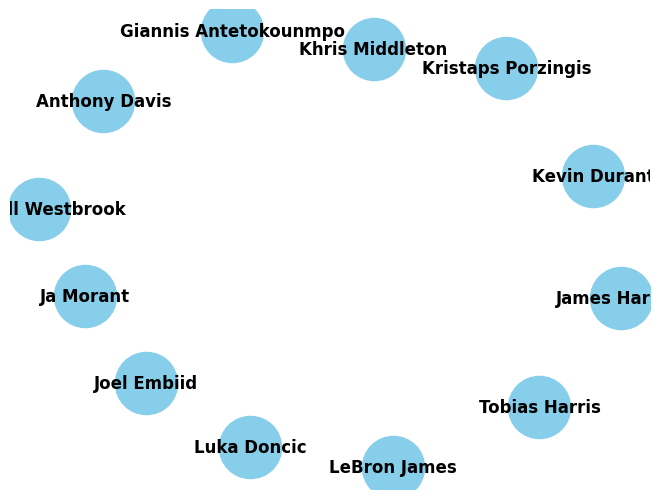

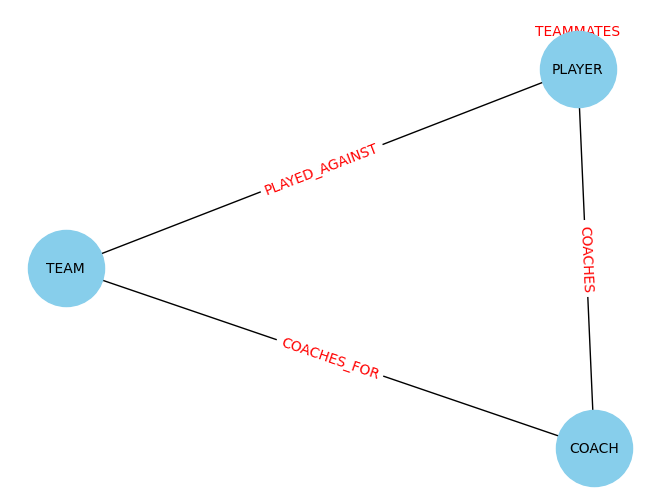

In [ ]:
query = "list of players"
answer(query)
Visualization_of_players()
Visualize_everythnig()